In [1]:
import numpy as np
import pandas as pd
import pypsa
import highspy
import matplotlib.pyplot as plt
from helper_functions import chp_unit_profile, apply_nuclear_outages


plt.rcParams['figure.figsize'] = [15, 9]
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FILE = 'EU-UK-WB-baseline-2030.xlsx'

In [4]:
# input parameters
P_MIN_NUCLEAR = 0.4

In [5]:
load = pd.read_excel(DATA_FILE, sheet_name='load', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
load_hydrogen = pd.read_excel(DATA_FILE, sheet_name='load_hydrogen', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
pv = pd.read_excel(DATA_FILE, sheet_name='pv', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
wind = pd.read_excel(DATA_FILE, sheet_name='wind', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
wind_offshore = pd.read_excel(DATA_FILE, sheet_name='wind_offshore', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
ror = pd.read_excel(DATA_FILE, sheet_name='ror', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
inflow = pd.read_excel(DATA_FILE, sheet_name='inflow', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
chp = pd.read_excel(DATA_FILE, sheet_name='chp', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
chp_bio = pd.read_excel(DATA_FILE, sheet_name='chp_bio', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()

buses = pd.read_excel(DATA_FILE, sheet_name='buses', index_col=0)
cbf_buses = pd.read_excel(DATA_FILE, sheet_name='cbf_buses', index_col=0)
buses_hydrogen = pd.read_excel(DATA_FILE, sheet_name='buses_hydrogen', index_col=0)
lines = pd.read_excel(DATA_FILE, sheet_name='lines', index_col='name').dropna(axis=1, how='all').dropna()
links = pd.read_excel(DATA_FILE, sheet_name='links', index_col=0).dropna(axis=1, how='all').dropna()
links_electrolysis = pd.read_excel(DATA_FILE, sheet_name='links_electrolysis', index_col=0).dropna(axis=1, how='all').dropna()
gen_pv = pd.read_excel(DATA_FILE, sheet_name='gen_pv', index_col=0)
gen_wind = pd.read_excel(DATA_FILE, sheet_name='gen_wind', index_col=0)
gen_wind_offshore = pd.read_excel(DATA_FILE, sheet_name='gen_wind_offshore', index_col=0)
gen_gas = pd.read_excel(DATA_FILE, sheet_name='gen_gas', index_col=0)
gen_oil = pd.read_excel(DATA_FILE, sheet_name='gen_oil', index_col=0)
gen_coal = pd.read_excel(DATA_FILE, sheet_name='gen_coal', index_col=0)
gen_nuclear = pd.read_excel(DATA_FILE, sheet_name='gen_nuclear', index_col=0)
gen_biomass = pd.read_excel(DATA_FILE, sheet_name='gen_biomass', index_col=0)
gen_biogas = pd.read_excel(DATA_FILE, sheet_name='gen_biogas', index_col=0)
gen_ror = pd.read_excel(DATA_FILE, sheet_name='gen_ror', index_col=0)
gen_reservoir = pd.read_excel(DATA_FILE, sheet_name='gen_reservoir', index_col=0)
gen_other_res = pd.read_excel(DATA_FILE, sheet_name='gen_other_res', index_col=0)
gen_dsr = pd.read_excel(DATA_FILE, sheet_name='gen_dsr', index_col=0)
gen_gas_chp = pd.read_excel(DATA_FILE, sheet_name='gen_gas_chp', index_col=0)
gen_coal_chp = pd.read_excel(DATA_FILE, sheet_name='gen_coal_chp', index_col=0)
gen_oil_chp = pd.read_excel(DATA_FILE, sheet_name='gen_oil_chp', index_col=0)
gen_res_chp = pd.read_excel(DATA_FILE, sheet_name='gen_res_chp', index_col=0)
gen_bio_chp = pd.read_excel(DATA_FILE, sheet_name='gen_bio_chp', index_col=0)
gen_cbf = pd.read_excel(DATA_FILE, sheet_name='gen_cbf', index_col=0)
st_hps = pd.read_excel(DATA_FILE, sheet_name='st_hps', index_col=0)
st_battery = pd.read_excel(DATA_FILE, sheet_name='st_battery', index_col=0)
st_hydrogen = pd.read_excel(DATA_FILE, sheet_name='st_hydrogen', index_col=0)
st_other = pd.read_excel(DATA_FILE, sheet_name='st_other', index_col=0)

In [14]:
# create chp timeseries based on country temperature profile
gas_chp_timeseries=chp_unit_profile(chp, gen_gas_chp)
coal_chp_timeseries=chp_unit_profile(chp, gen_coal_chp)
oil_chp_timeseries=chp_unit_profile(chp, gen_oil_chp)
res_chp_timeseries=chp_unit_profile(chp, gen_res_chp)

In [15]:
# create nuclear time series to replicate maintenance profile
nuclear_p_max_time_series, nuclear_p_min_time_series = apply_nuclear_outages(chp, gen_nuclear, nuclear_p_min=P_MIN_NUCLEAR, french_nucl_cf=0.85, other_nucl_cf=0.95)

In [37]:
network = pypsa.Network()
network.set_snapshots(load.index)

network.import_components_from_dataframe(buses, 'Bus')
network.import_components_from_dataframe(cbf_buses, 'Bus')
network.import_components_from_dataframe(buses_hydrogen, 'Bus')

network.import_components_from_dataframe(lines, 'Line')
network.lines['s_nom_extendable'] = True  

network.madd("Link", links.index,
             bus0=links['bus0'].tolist(), bus1= links['bus1'].tolist(),
             p_nom=links['p_nom'].tolist(), p_max_pu=links['p_max_pu'].to_list())

network.madd("Generator", gen_cbf.index, suffix='_CBF', carrier='CBF',
             bus=gen_cbf.index.tolist(), p_nom=gen_cbf['p_nom'].to_list(), p_nom_extendable=False, 
             marginal_cost=gen_cbf['marginal_cost'].to_list())

dict_carriers = {
    'Lignite': 0.334, 'Hard coal': 0.354, 'Gas': 0.187, 'Gas CCS': 0, 'Oil': 0.334, 'Hydrogen': 0, 'Biomass': 0.403, 'Biogas': 0.178, 'BECCS': 0,
    'Geothermal': 0.026, 'Wind': 0, 'Wind offshore': 0, 'PV': 0, 'HPS': 0, 'Hydro': 0, 'Other RES': 0, 'CBF': 0, 'VOLL': 0, 'Battery': 0, 'Other storage' : 0, 'Nuclear': 0, 'Electrolysis':0, 'Hydrogen storage':0, 'Hydrogen for power':0
}

for carrier in dict_carriers:
    network.add("Carrier", name=carrier, co2_emissions=dict_carriers[carrier])

network.madd("Load", load.columns, bus=load.columns, p_set=load)
network.madd("Load", load_hydrogen.columns, bus=load_hydrogen.columns, p_set=load_hydrogen, carrier='Hydrogen')

Index(['Austria_H2', 'Belgium_H2', 'Bulgaria_H2', 'Croatia_H2', 'Czechia_H2',
       'Denmark_H2', 'Estonia_H2', 'Finland_H2', 'France_H2', 'Germany_H2',
       'Greece_H2', 'Hungary_H2', 'Ireland_H2', 'Italy_H2', 'Latvia_H2',
       'Lithuania_H2', 'Netherlands_H2', 'Poland_H2', 'Portugal_H2',
       'Romania_H2', 'Slovakia_H2', 'Slovenia_H2', 'Spain_H2', 'Sweden_H2',
       'UK_H2', 'Norway_H2', 'Switzerland_H2', 'Albania_H2',
       'BosniaHerzegovina_H2', 'Kosovo_H2', 'Moldova_H2', 'Montenegro_H2',
       'NorthMacedonia_H2', 'Serbia_H2', 'Ukraine_H2'],
      dtype='object')

In [38]:
network.madd('Generator', 
      gen_pv['bus'],
      suffix='_PV',
      bus=gen_pv['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_pv['p_nom'].to_list(),
      carrier='PV', 
      marginal_cost=gen_pv['marginal_cost'].to_list(), 
      p_max_pu=pv)

network.madd('Generator', 
      gen_wind['bus'],
      suffix='_Wind',
      bus=gen_wind['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_wind['p_nom'].to_list(), 
      carrier='Wind', 
      marginal_cost=gen_wind['marginal_cost'].to_list(), 
      p_max_pu=wind)

network.madd('Generator', 
      gen_wind_offshore['bus'],
      suffix='_Wind_offshore',
      bus=gen_wind_offshore['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_wind_offshore['p_nom'].to_list(), 
      carrier='Wind offshore', 
      marginal_cost=gen_wind_offshore['marginal_cost'].to_list(), 
      p_max_pu=wind_offshore)


network.madd('Generator', 
      gen_gas.index,
      bus=gen_gas['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_gas['p_nom'].to_list(), 
      carrier=gen_gas['carrier'].to_list(), 
      marginal_cost=gen_gas['marginal_cost'].to_list(),
      efficiency=gen_gas['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_oil.index,
      bus=gen_oil['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_oil['p_nom'].to_list(), 
      carrier='Oil', 
      marginal_cost=gen_oil['marginal_cost'].to_list(),
      efficiency=gen_oil['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_coal.index,
      bus=gen_coal['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_coal['p_nom'].to_list(), 
      carrier=gen_coal['carrier'].to_list(), 
      marginal_cost=gen_coal['marginal_cost'].to_list(),
      efficiency=gen_coal['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_nuclear.index,
      bus=gen_nuclear['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_nuclear['p_nom'].to_list(), 
      carrier='Nuclear', 
      marginal_cost=gen_nuclear['marginal_cost'].to_list(),
      efficiency=gen_nuclear['efficiency'].to_list(),
      p_max_pu=nuclear_p_max_time_series,
      p_min_pu=nuclear_p_min_time_series
      )

network.madd('Generator', 
      gen_biomass.index,
      bus=gen_biomass['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_biomass['p_nom'].to_list(), 
      carrier=gen_biomass['carrier'].to_list(), 
      marginal_cost=gen_biomass['marginal_cost'].to_list(),
      efficiency=gen_biomass['efficiency'].to_list(),
      p_max_pu=gen_biomass['p_max_pu'].to_list()
      )

network.madd('Generator', 
      gen_biogas['bus'],
      suffix='_Biogas',
      bus=gen_biogas['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_biogas['p_nom'].to_list(), 
      carrier='Biogas', 
      marginal_cost=gen_biogas['marginal_cost'].to_list(),
      efficiency=gen_biogas['efficiency'].to_list(),
      p_max_pu=gen_biogas['p_max_pu'].to_list()
      )

network.madd('Generator', 
       gen_ror.index,
       bus=gen_ror['bus'].to_list(), 
       p_nom_extendable=False, 
       p_nom=gen_ror['p_nom'].to_list(), 
       carrier=gen_ror['carrier'].to_list(),
       marginal_cost=gen_ror['marginal_cost'].to_list(),
       p_max_pu=ror
       )

network.madd('Generator', 
       gen_reservoir.index,
       bus=gen_reservoir['bus'].to_list(), 
       p_nom_extendable=False, 
       p_nom=gen_reservoir['p_nom'].to_list(), 
       carrier=gen_reservoir['carrier'].to_list(),
       marginal_cost=gen_reservoir['marginal_cost'].to_list(),
       p_max_pu=inflow
       )

network.madd('Generator', 
      gen_other_res['bus'],
      suffix='_OtherRES',
      bus=gen_other_res['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_other_res['p_nom'].to_list(), 
      carrier='Other RES', 
      marginal_cost=gen_other_res['marginal_cost'].to_list(),
      p_max_pu=gen_other_res['p_max_pu'].to_list()
      )

network.madd('Generator', 
      gen_dsr['bus'],
      suffix='_DSR',
      bus=gen_dsr['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_dsr['p_nom'].to_list(), 
      carrier='DSR', 
      marginal_cost=gen_dsr['marginal_cost'].to_list(),
      p_max_pu=gen_dsr['p_max_pu'].to_list()
      )

network.madd('Generator', 
      gen_gas_chp.index,
      bus=gen_gas_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_gas_chp['p_nom'].to_list(), 
      carrier=gen_gas_chp['carrier'].to_list(), 
      marginal_cost=gen_gas_chp['marginal_cost'].to_list(),
      p_max_pu=gas_chp_timeseries,
      p_min_pu=0.9*gas_chp_timeseries,
      efficiency=gen_gas_chp['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_coal_chp.index,
      bus=gen_coal_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_coal_chp['p_nom'].to_list(), 
      carrier=gen_coal_chp['carrier'].to_list(), 
      marginal_cost=gen_coal_chp['marginal_cost'].to_list(),
      p_max_pu=coal_chp_timeseries,
      p_min_pu=0.9*coal_chp_timeseries,
      efficiency=gen_coal_chp['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_oil_chp.index,
      bus=gen_oil_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_oil_chp['p_nom'].to_list(), 
      carrier=gen_oil_chp['carrier'].to_list(), 
      marginal_cost=gen_oil_chp['marginal_cost'].to_list(),
      p_max_pu=oil_chp_timeseries,
      p_min_pu=0.9*oil_chp_timeseries,
      efficiency=gen_oil_chp['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_res_chp.index,
      bus=gen_res_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_res_chp['p_nom'].to_list(), 
      carrier=gen_res_chp['carrier'].to_list(), 
      marginal_cost=gen_res_chp['marginal_cost'].to_list(),
      p_max_pu=res_chp_timeseries,
      p_min_pu=0.9*res_chp_timeseries,
      efficiency=gen_res_chp['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_bio_chp.index,
      bus=gen_bio_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_bio_chp['p_nom'].to_list(), 
      carrier=gen_bio_chp['carrier'].to_list(), 
      marginal_cost=gen_bio_chp['marginal_cost'].to_list(),
      p_max_pu=chp_bio,
      p_min_pu=chp_bio*0.9,
      efficiency=gen_bio_chp['efficiency'].to_list()
      )

network.madd("StorageUnit", st_hps.index, bus=st_hps['bus'].tolist(), carrier=st_hps['carrier'].tolist(),
             p_nom=st_hps['p_nom'].tolist(), p_nom_extendable=False, max_hours=st_hps['max_hours'].to_list(),
             p_max_pu=st_hps['p_max_pu'].tolist(),
             efficiency_dispatch=st_hps['efficiency_dispatch'].tolist(),
             standing_loss=st_hps['standing_loss'].tolist())
            
network.madd("StorageUnit", st_battery.index, bus=st_battery['bus'].tolist(), carrier=st_battery['carrier'].tolist(),
             p_nom=st_battery['p_nom'].tolist(), p_nom_extendable=False, max_hours=st_battery['max_hours'].to_list(),
             p_max_pu=st_battery['p_max_pu'].tolist(),
             efficiency_dispatch=st_battery['efficiency_dispatch'].tolist(),
             standing_loss=st_battery['standing_loss'].tolist())

network.madd("StorageUnit", st_other.index, bus=st_other['bus'].tolist(), carrier=st_other['carrier'].tolist(),
             p_nom=st_other['p_nom'].tolist(), p_nom_extendable=False, max_hours=st_other['max_hours'].to_list(),
             p_max_pu=st_other['p_max_pu'].tolist(),
             efficiency_dispatch=st_other['efficiency_dispatch'].tolist(),
             standing_loss=st_other['standing_loss'].tolist())

network.madd("Link", links_electrolysis.index,
             bus0=links_electrolysis['bus0'].tolist(), bus1= links_electrolysis['bus1'].tolist(),
             p_nom=links_electrolysis['p_nom'].tolist(), p_nom_extendable=links_electrolysis['p_nom_extendable'].tolist(), carrier=links_electrolysis['carrier'].tolist(), 
             efficiency=links_electrolysis['efficiency'].tolist())

network.madd("Store", st_hydrogen.index, bus=st_hydrogen['bus'].tolist(), carrier=st_hydrogen['carrier'].tolist(),
             e_nom=st_hydrogen['e_nom'].tolist(), e_nom_extendable=False, e_cyclic=True)

Index(['Austria_H2_Storage', 'Belgium_H2_Storage', 'Bulgaria_H2_Storage',
       'Croatia_H2_Storage', 'Czechia_H2_Storage', 'Denmark_H2_Storage',
       'Estonia_H2_Storage', 'Finland_H2_Storage', 'France_H2_Storage',
       'Germany_H2_Storage', 'Greece_H2_Storage', 'Hungary_H2_Storage',
       'Ireland_H2_Storage', 'Italy_H2_Storage', 'Latvia_H2_Storage',
       'Lithuania_H2_Storage', 'Netherlands_H2_Storage', 'Poland_H2_Storage',
       'Portugal_H2_Storage', 'Romania_H2_Storage', 'Slovakia_H2_Storage',
       'Slovenia_H2_Storage', 'Spain_H2_Storage', 'Sweden_H2_Storage',
       'UK_H2_Storage', 'Norway_H2_Storage', 'Switzerland_H2_Storage',
       'Albania_H2_Storage', 'BosniaHerzegovina_H2_Storage',
       'Kosovo_H2_Storage', 'Moldova_H2_Storage', 'Montenegro_H2_Storage',
       'NorthMacedonia_H2_Storage', 'Serbia_H2_Storage', 'Ukraine_H2_Storage'],
      dtype='object', name='name')

In [39]:
network.consistency_check()

(<matplotlib.collections.PatchCollection at 0x7f1a3649e850>,
 <matplotlib.collections.LineCollection at 0x7f1a3b1c9820>)

/home/harri/venv/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



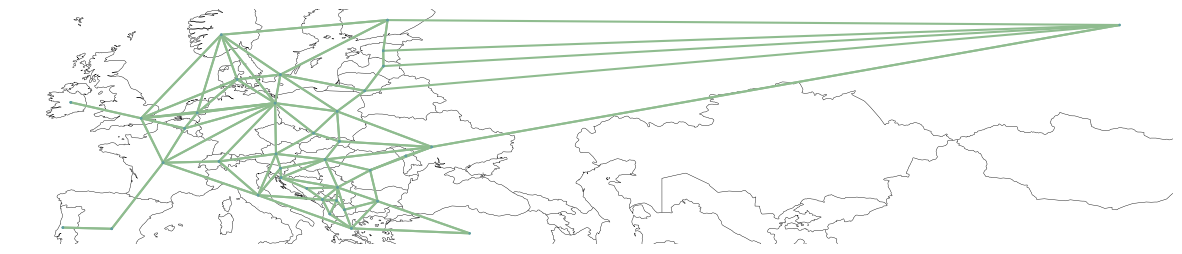

In [40]:
network.plot(geomap=True)

In [41]:
network.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.15s/it]
INFO:linopy.io: Writing time: 242.2s
INFO:linopy.solvers:Log file at /tmp/highs.log.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
Problem status detected on presolve: Infeasible
Model   status      : Infeasible
Objective value     :  0.0000000000e+00
HiGHS run time      :         30.65


Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: infeasible



('warning', 'infeasible')

In [43]:
# generation by fuel
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
generation_by_fuel_yearly = p_by_carrier.sum()/1000000
generation_by_fuel_yearly

Series([], dtype: float64)

In [44]:
# Generation by fuel by country with exports to csv
p_by_carrier = network.generators_t.p.groupby([network.generators.carrier, network.generators.bus], axis=1).sum()
generation_by_fuel_by_country = p_by_carrier.sum()/1000000
generation_by_fuel_by_country.to_csv('generation_by_fuel_by_country.csv')

In [45]:
# Generation by unit with exports to csv
p_by_unit = network.generators_t.p.sum()/1000000
generation_by_unit = p_by_unit
generation_by_unit.to_csv('generation_by_unit.csv')

In [46]:
# Interconnector flows with exports to csv
generation_by_link = network.links_t.p0.sum()/1000000
generation_by_link.to_csv('generation_by_link.csv')

In [47]:
# Capacity by fuel
capacity_by_fuel = network.generators.groupby("carrier")["p_nom"].sum()
capacity_by_fuel

carrier
BECCS               550.000000
Biogas            13957.919105
Biomass           21145.628923
CBF              100000.000000
DSR              150284.340304
Gas              215942.070000
Hard coal         42581.000000
Hydro            182764.000000
Lignite           34476.000000
Nuclear          111074.000000
Oil               27499.000000
Other RES         19578.378009
PV               682770.000000
Wind             411406.000000
Wind offshore    151730.000000
Name: p_nom, dtype: float64

In [48]:
# Capacity by fuel by country with exports to csv
capacity_by_fuel = network.generators.groupby(["carrier","bus"])["p_nom"].sum()
capacity_by_fuel.to_csv('capacity_by_fuel_by_country.csv')